In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf  # Statsmodels is a Python module for statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF 
from statsmodels.stats.anova import anova_lm

from ISLP import load_data    # ISLP library for the book, it has built in functions and methods to build models 
from ISLP.models import (ModelSpec as MS, summarize , poly) # It also has built-in data that can be loaded

import matplotlib as mpl


#For inline plotting 
%matplotlib inline                 
%config InlineBackend.figure_format = 'svg'


sns.set(style="white") # Plot parameters defined globally
plt.style.use("seaborn-v0_8-white")

## **3.9 Multiple linear regression with the Auto.csv**

In [2]:
df = pd.read_csv('Auto.csv', na_values = ['?']).dropna()
df.head() 

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


In [3]:
df.isna().any()

mpg             False
cylinders       False
displacement    False
horsepower      False
weight          False
acceleration    False
year            False
origin          False
name            False
dtype: bool

### a)

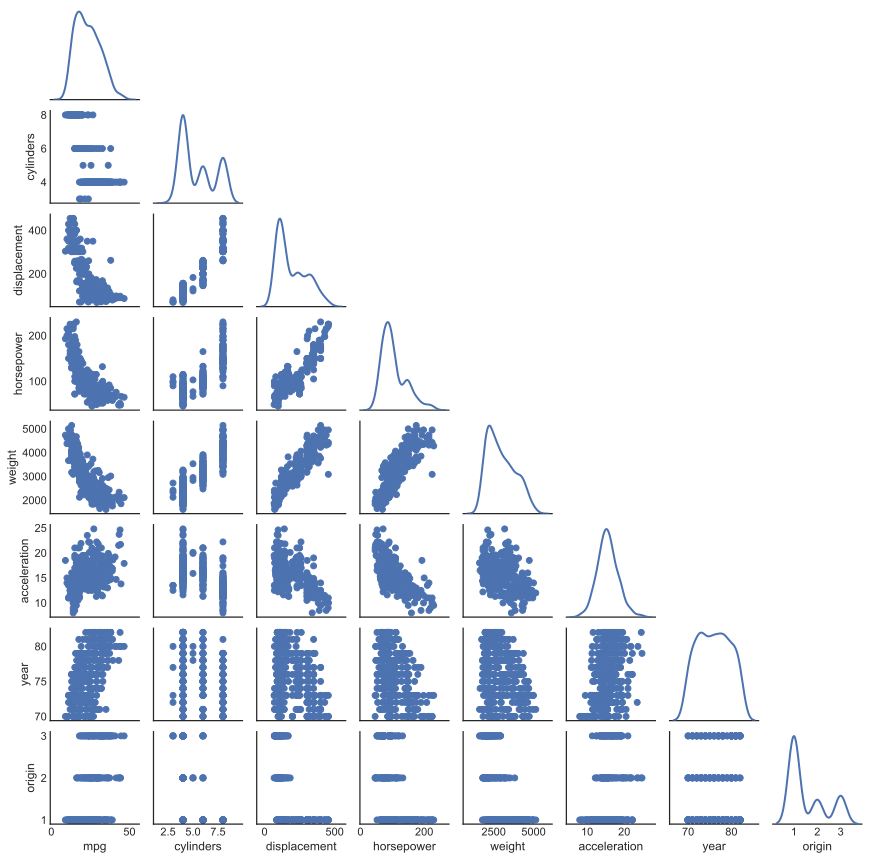

In [4]:
sns_pmatrix = sns.PairGrid(df, diag_sharey = False, corner = True, layout_pad=0.7)

sns_pmatrix.map_lower(plt.scatter)
sns_pmatrix.map_diag(sns.kdeplot, lw=2, legend=False)

sns_pmatrix.fig.set_figheight(12)
sns_pmatrix.fig.set_figwidth(12)

### b)

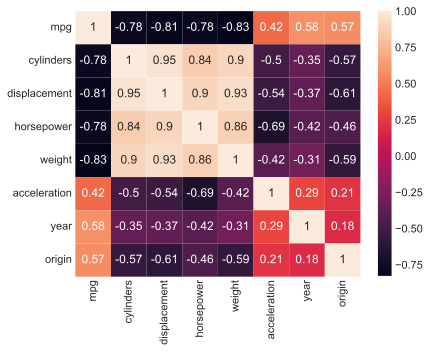

In [6]:
quant_df = df.drop('name', axis = 1)
corr_M = quant_df.corr()

sns.heatmap(corr_M, annot= True);


### c)

In [7]:
X = df.drop(['name','mpg'], axis = 1)

X_train = sm.add_constant(X)

y_train = df['mpg']

X_train.head()

,const,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,1.0,8,307.0,130.0,3504,12.0,70,1
1,1.0,8,350.0,165.0,3693,11.5,70,1
2,1.0,8,318.0,150.0,3436,11.0,70,1
3,1.0,8,304.0,150.0,3433,12.0,70,1
4,1.0,8,302.0,140.0,3449,10.5,70,1


In [8]:
MLreg_model = sm.OLS(y_train, X_train)

MLreg_results = MLreg_model.fit()

print(MLreg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     252.4
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          2.04e-139
Time:                        16:45:49   Log-Likelihood:                -1023.5
No. Observations:                 392   AIC:                             2063.
Df Residuals:                     384   BIC:                             2095.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -17.2184      4.644     -3.707   

### i. There is a clearly visible correlation between some of the predictors and the response (target). F-statistics is much larger than unity and the probability Prob(F-stat) that this data can be generated if null hypothesis true is extremely low. This reflects the fact that we can reject the null hypothesis.

### ii. Looking at p-values, we can say that displacement, weight, year and origin have high statistical relevance for the response whereas cylinders, horsepower and acceleration do not have some much statistically significant relationship with mpg. 

### iii. Year is one of the most important predictor in determining the response. One unit of change in year increases the mpg by 0.75 units. 

### d)

In [11]:
fit_vals = MLreg_results.fittedvalues
resid = MLreg_results.resid

# Find top 3 points with largest residuals, get their index to annote later in the plot below 

abs_resid = np.abs(resid).sort_values(ascending = False)
t3abs_resid = abs_resid[:3]

(5.247689711057625, 37.4874434983991)

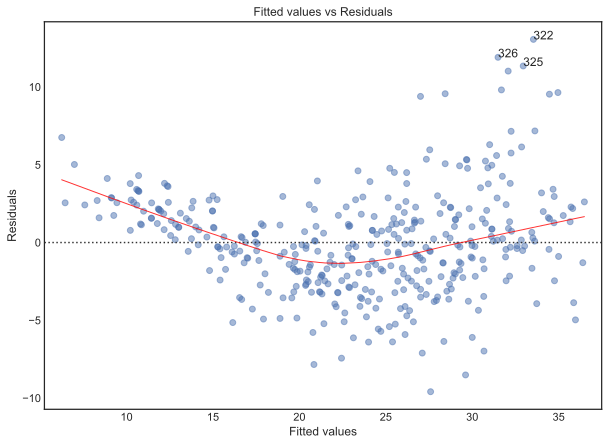

In [12]:
fig, ax = plt.subplots(1,1,figsize = (10,7))

ax = sns.residplot(data = df, x = fit_vals, y= resid, lowess=True,
                                  scatter_kws={'alpha': 0.5},
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

for i in t3abs_resid.index:
                    ax.annotate(i, 
                               xy=(fit_vals[i], 
                                   resid[i]));

ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted values vs Residuals')
ax.set_xlim(fit_vals.min()-1,fit_vals.max()+1)

### Compared to the simple linear regression model, pattern in the residuals is less but there is still some non-linearity

In [16]:
norm_resid = MLreg_results.get_influence().resid_studentized_internal
leverage = MLreg_results.get_influence().hat_matrix_diag

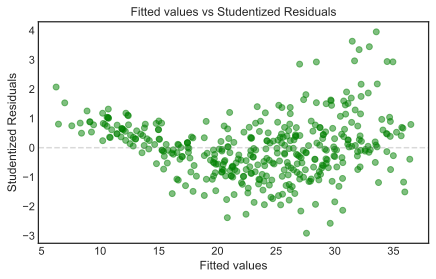

In [17]:
# Look at the effect of unusually large outliers by plotting studentized residuals vs fitted values of y

fig, ax = plt.subplots(1,1,figsize = (7,4))

ax.set_xlabel('Fitted values')
ax.set_ylabel('Studentized Residuals')
ax.set_title('Fitted values vs Studentized Residuals')

ax.axhline(0, color = 'gray', linestyle = '--', alpha = 0.3)

ax = plt.scatter(fit_vals,norm_resid, color = 'green', alpha = 0.5)

### There is not unusually large outliers with S.residuals >> 3, however for larger fitted values, the spread of the residuals increases indicating heteroskedacity.

In [18]:
# Cook's distance can be used to identify influential observations in a regression model. 
# Essentially Cook’s distance measures how much all of the fitted values in the model change when the ith observation is deleted.

# The larger the value for Cook’s distance, the more influential a given observation.

cooks = MLreg_results.get_influence().cooks_distance # returns the cooks distance for each oberservation i and the corresponding p-values 

#cooks[0] returns the cooks distances

# top 3 influential observations according to Cooks distance, argsort() returns the cooks distance in ascending order so we flip to
# get the top 3

top_cooks = np.flip(np.argsort(cooks[0]),0)[:3] 

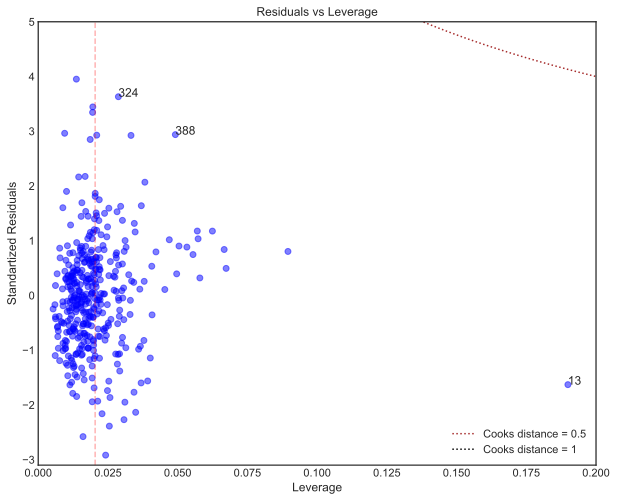

In [19]:
fig, axes = plt.subplots(1,1,figsize = (10,8))

axes.set_xlim(0, 0.2)
axes.set_ylim(-3.1, 5)
axes.set_title('Residuals vs Leverage')
axes.set_xlabel('Leverage')
axes.set_ylabel('Standartized Residuals')

for obs in top_cooks:
    axes.annotate(obs, xy = (leverage[obs],norm_resid[obs]))

p = len(MLreg_results.params) - 1 # number of predictors 
n = len(df) # number of observations 
axes.axvline((p+1)/n, linestyle = 'dashed', color = 'red', alpha = 0.3) # average leverage of all the observations 

# Cooks distance = 0.5 plot in the leverage vs residuals plane 
x = np.linspace(0.01,0.2,100)

def cooks_dy(l,d):
    return np.sqrt((p+1) * d * (1-l)/l)

axes.plot(x, cooks_dy(x, d = 0.5), label = 'Cooks distance = 0.5', ls = ':' , color = 'brown')
axes.plot(x, cooks_dy(x, d = 1), label = 'Cooks distance = 1', ls = ':' , color = 'black')
axes.legend(loc = 'best')

axes.scatter(leverage,norm_resid, alpha = 0.5, color = 'blue')

### Observation 13 appears to have unusually high leverage compared to the average leverage of the sample (vertical dashed red line). But it is still far away from significant cooks distance in the residuals vs leverage plane indicating it would not influence the fit as much.

### e)

### Lots of different couplings can be considered. For example, cars built in more recent years have less weight and horsepower. Cylinder numbers seem to affect the weight as well. Lets add all to see if the model is improved.

In [20]:

X_train['cylinders:weight'] = X_train['cylinders'] * X_train['weight']
X_train['year:weight'] = X_train['year'] * X_train['weight']
X_train['year:horsepower'] = X_train['year'] * X_train['horsepower']

In [22]:
MLreg_model = sm.OLS(y_train, X_train)

MLreg_results = MLreg_model.fit()

print(MLreg_results.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     258.8
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          4.68e-163
Time:                        17:29:25   Log-Likelihood:                -958.79
No. Observations:                 392   AIC:                             1940.
Df Residuals:                     381   BIC:                             1983.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -50.8646     14.643  

### Year-weight interaction does not appear to be statistically significant however cylinder:weight and year:horsepower interactions are statistically significant. Lets add origin:displacement, origin:horsepower, displacement:weight, displacement:horsepower AND drop accelerelation with low t-statistics 

In [23]:
X_train['origin:horsepower'] = X_train['origin'] * X_train['horsepower']
X_train['origin:displacement'] = X_train['origin'] * X_train['displacement']
X_train['weight:displacement'] = X_train['weight'] * X_train['displacement']
X_train['horsepower:displacement'] = X_train['horsepower'] * X_train['displacement']


X_train = X_train.drop(['acceleration'], axis = 1)


MLreg_model2 = sm.OLS(y_train, X_train)

MLreg_results2 = MLreg_model2.fit()

print(MLreg_results2.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     212.5
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.02e-164
Time:                        17:33:20   Log-Likelihood:                -946.21
No. Observations:                 392   AIC:                             1920.
Df Residuals:                     378   BIC:                             1976.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

### These results indicate that the interactions that appear to be statistically significant are displacement:weight, horsepower:origin and horsepower:year. 

### f)

In [26]:
X = df.drop(['name','mpg'], axis = 1)

X_train = sm.add_constant(X)

In [27]:
# Lets apply all the x-forms to horsepower, drop cylinders and acceleration


X_train['horsepowersq'] = np.power(X_train['horsepower'],2)
X_train['horsepowersqr'] = np.sqrt(X_train['horsepower'])
X_train['horsepowerlog'] = np.log(X_train['horsepower'])

X_train.drop(['acceleration','cylinders'], axis = 1, inplace = True)

MLreg_modelm = sm.OLS(y_train, X_train)

MLreg_resultsm = MLreg_modelm.fit()

print(MLreg_resultsm.summary())

                            OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.859
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     290.6
Date:                Tue, 19 Dec 2023   Prob (F-statistic):          1.69e-157
Time:                        17:47:19   Log-Likelihood:                -977.86
No. Observations:                 392   AIC:                             1974.
Df Residuals:                     383   BIC:                             2009.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -426.1329    167.499     -2.544

### All non-linearities in horsepower seems to be relevant

In [28]:
fit_vals = MLreg_resultsm.fittedvalues
resid = MLreg_resultsm.resid

# Find top 3 points with largest residuals, get their index to annote later in the plot below 

abs_resid = np.abs(resid).sort_values(ascending = False)
t3abs_resid = abs_resid[:3]

(7.650706138791065, 39.618643215584825)

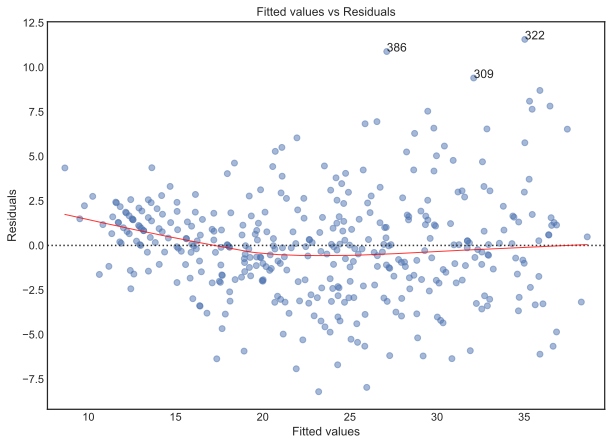

In [29]:
fig, ax = plt.subplots(1,1,figsize = (10,7))

ax = sns.residplot(data = df, x = fit_vals, y= resid, lowess=True,
                                  scatter_kws={'alpha': 0.5},
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

for i in t3abs_resid.index:
                    ax.annotate(i, 
                               xy=(fit_vals[i], 
                                   resid[i]));

ax.set_xlabel('Fitted values')
ax.set_ylabel('Residuals')
ax.set_title('Fitted values vs Residuals')
ax.set_xlim(fit_vals.min()-1,fit_vals.max()+1)

### No significant pattern is present in the residuals as compared to the linear model. Therefore, we can say that model including non-linearities works better. 

## **References**

### It turns out that in R, plotting diagnostic plots to test the performence of linear regression procedure is much easier. I followed the link below to generate plots similar to the main text for diagnosis of heteroskasdicity, outliers, leverage points and nonlinearity. 

- https://emredjan.medium.com/emulating-r-regression-plots-in-python-43741952c034

### Cooks distance: 

- https://en.wikipedia.org/wiki/Cook%27s_distance

### Introduction to Statistical Learning with Python: 

- [Introduction to Statistical Learning with Python](https://www.statlearning.com/). 